In [ ]:
import pandas as pd
import re
from string import printable
from collections import OrderedDict
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn


filename = '/Users/mitalipalsikar/Documents/year3project/Daily Twitter/twitterData.csv'
vaderFile = '/Users/mitalipalsikar/Documents/year3project/Daily Twitter/vaderResults.csv'
swnFile = '/Users/mitalipalsikar/Documents/year3project/Daily Twitter/swnResults.csv'

df = pd.read_csv(filename, encoding='utf-8')


class preprocessData():
    
    currPairs = set(["EURUSD", "USDJPY", "GBPUSD", "USDCAD", "USDCHF", "AUDUSD"])
    
    #remove 'not' from list of stopwords for sentiment analysis
    stopwords = set(stopwords.words('english'))
    stopwords.remove('not')
    ch = [',', '.', '/', '\\']
          
    #remove rows which have more than one cashtag (possible spam)
    def invalid(self, x):
        seen = set()
        for i in x.split():
            if i in self.currPairs:
                seen.add(i)
            if len(seen) >2:
                return False
        return True
          
    #preprocess data
    def preprocess(self):
        global df
        df['PP Text'] = df['Text'].map(lambda x: ' '.join(re.sub("(RT)|(@[A-Za-z0-9]+)|(pic.twitter.com\/+\S+)|([^0-9A-Za-z!? \t]+)|(\w+:\/\/\S+)"," ",x).split()))
        df['PP Text'] = ["".join([x for x in tweet if not x.isdigit() and x not in self.ch]) for tweet in df['PP Text']]
        df['PP Text'] = [" ".join([word for word in x.split() if len(word) > 2 and word not in (self.stopwords)]) for x in df['PP Text']]

        #Remove duplicated words
        df['PP Text'] = df['PP Text'].apply(lambda x: " ".join(sorted(set(x.split()), key=x.split().index)))

        #remove stopwords and words > 2
        #df['PP Text'] = df['PP Text'].apply(lambda x:' '.join([word for word in x.split() if word not in (self.stopwords) )
        #df['Timestamp'] = pd.to_datetime(df['Timestamp'].str.slice(1))

class SentimentAnalysis():

    svalues = []
    lvalues = [] 

    lemmatizer = WordNetLemmatizer()
    #Convert tags to  Wordnet tags
    def convertWN(self, tag):

        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        elif tag.startswith('V'):
            return wn.VERB
        return None
    
    def swnSentiment(self, sentence):
        sentiment = 0.0
        tagged=nltk.pos_tag(nltk.word_tokenize(sentence))
        for word, tag in tagged:
            wnTag = self.convertWN(tag)
            if wnTag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue

            lemma = self.lemmatizer.lemmatize(word, pos=wnTag)
            if not lemma:
                continue

            synsets = wn.synsets(lemma, pos=wnTag)
            if not synsets:
                continue
            # Take the first sense, the most common
            synset = synsets[0]
            swnscore = swn.senti_synset(synset.name())
            sentiment += (swnscore.pos_score() - swnscore.neg_score())
        return sentiment

    def sentiWordNet(self):
        i = 0;
        global df
        for row in df.values:
            sentence = row[5]
            sd = {}
            date = row[0]
            sentiment = self.swnSentiment(sentence);
            sd['Tweet'] = sentence
            sd['Date'] = date
            sd['Sentiment'] = sentiment
            self.svalues.append(sd)
            i = i+1
            print(i)
        sdf = pd.DataFrame(self.svalues)
        print("Done")
        return sdf   

    def vaderSentiment(self):

        sid = SentimentIntensityAnalyzer()
        i = 0;
        global df
        for row in df.values:
            sentence = row[5]
            date = row[0]
            ss = sid.polarity_scores(sentence)    
            ss['Tweet'] = sentence
            ss['Date'] = date
            self.lvalues.append(ss)
            i = i + 1
            print(i)
        vdf = pd.DataFrame(self.lvalues)
        vdf['Label'] = vdf['compound'].apply(self.setLabels)

        print("Finished Vader Sentiment Analysis")
        return vdf
    
    def setLabels(self, num):

        if(num > 0.3):
            label = 1
        elif (num < -0.3):
            label = -1
        else:
            label = 0
        return label


# pp = preprocessData()
# pp.preprocess()
# df = df[df['PP Text'].apply(pp.invalid)]
# df.to_csv(filename, encoding='utf-8', index=False)

ss = SentimentAnalysis()

# vdf = ss.vaderSentiment()
# vdf.to_csv(vaderFile, index=False)

sdf = ss.sentiWordNet()
sdf['Norm Sentiment'] = (sdf['Sentiment'] - sdf['Sentiment'].mean()) / (sdf['Sentiment'].max() - sdf['Sentiment'].min())
sdf['Label'] = sdf['Norm Sentiment'].apply(ss.setLabels)
sdf.to_csv(swnFile, index=False)


In [ ]:
### NAIVE BAYES CLASSIFICATION ###
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

def getFScore(set1, set2):
    
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import accuracy_score
    result = {
        'macro': ' ',
        'micro': ' ',
        'weighted': ' '
    }
    #accuracy_score(predicted['Result'], yTest)
    result["macro"] = precision_recall_fscore_support(set1, set2, average='macro')
    result["micro"] = precision_recall_fscore_support(set1, set2, average='micro')
    result["weighted"] = precision_recall_fscore_support(set1, set2, average='weighted')
    
    return result


sdf = pd.read_csv('/Users/mitalipalsikar/Documents/year3project/Daily Twitter/vaderResults.csv', encoding='utf-8')

X  = sdf['Tweet'] # all samples
Y  = sdf['Label'] # all labels

#Create train and test data sets
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.3)

#Create Feature Vectors
vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(xTrain)
x_train_counts = x_train_counts.toarray()

#Create vocabulary and feature weights from training data
tf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.fit_transform(x_train_counts)

#Classification model
#clf = linear_model.SGDClassifier(class_weight="balanced").fit(X_train_tf, yTrain)
clf = MultinomialNB(class_prior=[0.1, 0.2, 0.7]).fit(X_train_tf, yTrain)
docs_new = xTest
X_new_counts = vectorizer.transform(docs_new)
X_new_tf = tf_transformer.transform(X_new_counts)

predicted = pd.DataFrame(columns=[ 'Tweet', 'Targeted', 'Result'])
#predicted['Tweet'] = xTest.values
predicted['Targeted'] = yTest.values
predicted['Result'] = clf.predict(X_new_tf)
result = getFScore(yTest, predicted['Result'])

#predicted.to_csv('/Users/mitalipalsikar/Documents/year3project/Daily Twitter/NBVader.csv', index=False)


/Users/mitalipalsikar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


ADF Statistic: -10.066942
p-value: 0.0000000000000000128881711
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


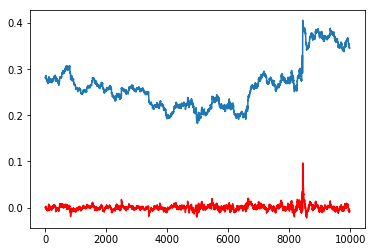

In [96]:
%matplotlib inline
import pandas as pd
from pandas import Series
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from numpy import log

#open prices by default
series = Series.from_csv('/Users/mitalipalsikar/Documents/year3project/Daily Rates/fxhistoricaldataGBPUSD.csv', header=0)
X = series.values
X = log(X)
#X_diff = np.diff(X, n=2)

# moving_avg = pd.rolling_mean(X,24)
# X_moving_avg_diff = X - moving_avg
# X_diff = X_moving_avg_diff[~np.isnan(X_moving_avg_diff)]

expweighted_avg = pd.ewma(X, halflife=24)
X_expweighted_avg_diff = X - expweighted_avg
X_diff = X_expweighted_avg_diff[~np.isnan(X_expweighted_avg_diff)]
result = adfuller(X_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %.25f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# plt.plot(X)
# plt.plot(X_diff, color='red')

# plt.plot(X_log, color='red')
# plt.plot(expweighted_avg, color='green')
# plt.plot(X_expweighted_avg_diff, color='red')


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fxFile = '/Users/mitalipalsikar/Documents/year3project/Daily Rates/fxhistoricaldataGBPUSD.csv'

#Get sentiment analysis for all tweets talking about $GBPUSD
gbpusd = sdf[sdf['Tweet'].str.contains("GBPUSD") ]
gbpusd.set_index('Date', inplace=True)
gbpusd.index = pd.to_datetime(gbpusd.index)
# Load libraries
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
fx = pd.read_csv(fxFile)
isBusinessDay = BDay().onOffset
match_series = pd.to_datetime(fx['Time']).map(isBusinessDay)
fx = fx[match_series]

#FX values for GBPUSD for same date range
fx = fx[(fx['Time'] >= '2017-10-13') & (fx['Time'] < '2017-10-28 00:00:00')]
fx.set_index('Time', inplace=True)
fx.index = pd.to_datetime(fx.index)

def plotChanges( fxval, senval):
    
    senval= senval.resample('D').std()
    fxval= fxval.resample('D').std()
    
    #senval = senval.replace([np.inf, -np.inf], np.nan)
    #fxval = fxval.replace([np.inf, -np.inf], np.nan)

    fxval = fxval.fillna(method='ffill')
    senval = senval.fillna(method='ffill')

    fxfig = fxval.plot( y = 'Close', marker='o', color='r', use_index=True)
    swnfig = senval.plot( y = 'Sentiment', marker='o', use_index=True)
    fxfig.get_figure().savefig('/Users/mitalipalsikar/Documents/year3project/presentation1/demoGBPUSD.png')
    swnfig.get_figure().savefig('/Users/mitalipalsikar/Documents/year3project/presentation1/demoswn.png')

plotChanges(fx, gbpusd)

In [ ]:

import pandas as pd
from collections import Counter, defaultdict
import numpy as np
import json

test = pd.read_csv('/Users/mitalipalsikar/Documents/year3project/Daily Twitter/twitterData.csv', encoding='utf-8')


#Create Naive Bayes Training Data
class NBTrainDataset():
    
    vr = pd.read_csv('/Users/mitalipalsikar/Documents/year3project/Daily Twitter/vaderResults.csv', encoding='utf-8')
    sr = pd.read_csv('/Users/mitalipalsikar/Documents/year3project/Daily Twitter/swnResults.csv', encoding='utf-8')
    currPairs = ["EURUSD", "USDJPY", "GBPUSD", "USDCAD", "USDCHF", "AUDUSD"]
    
    def createPosData(self):
        posdata = pd.DataFrame(columns=['Tweet'])
        for pair in self.currPairs:
            posdata = posdata.append(self.vr[self.vr['Tweet'].str.contains(pair) ].sort_values('compound', ascending=False)[['Tweet']].head(500), ignore_index=True)
            posdata = posdata.append(self.sr[self.sr['Tweet'].str.contains(pair) ].sort_values('Sentiment', ascending=False)[['Tweet']].head(500), ignore_index=True)

        posdata['Label'] = "pos"
        return posdata

    def createNegData(self):
        negdata = pd.DataFrame(columns=['Tweet'])
        for pair in self.currPairs:
            negdata = negdata.append(self.vr[self.vr['Tweet'].str.contains(pair) ].sort_values('compound', ascending=True)[['Tweet']].head(500), ignore_index=True)
            negdata = negdata.append(self.sr[self.sr['Tweet'].str.contains(pair) ].sort_values('Sentiment', ascending=True)[['Tweet']].head(500), ignore_index=True)

        negdata['Label'] = "neg"
        return negdata

    def traindata(self):
        traindata = pd.DataFrame(columns=['Tweet'])
        traindata = traindata.append(self.createPosData())
        traindata = traindata.append(self.createNegData())
 
        traindata = traindata.drop_duplicates(subset='Tweet', keep='first')
        return traindata

class NBBaseClass:
    def relOccurences(self, list1):
        no_examples = len(list1)
        ro_dict = dict(Counter(list1))
        for key in ro_dict.keys():
            ro_dict[key] = ro_dict[key] / float(no_examples)
        return ro_dict
 
    def get_max_value_key(self, d1):
        values = list(d1.values())
        keys = list(d1.keys())
        max_value_index = values.index(max(values))
        max_key = keys[max_value_index]
        return max_key
        
    def initNBDict(self):
        self.nbdict = {}
        for label in self.labels:
            self.nbdict[label] = defaultdict(list)    

class NaiveBayesText(NBBaseClass):
    
    def initNBDict(self):
        self.nbdict = {}
        for label in self.labels:
            self.nbdict[label] = []
            
    def train(self, X, Y):
        self.class_probabilities = self.relOccurences(Y)
        self.labels = np.unique(Y)
        self.no_examples = len(Y)
        self.initNBDict()
        for i in range(0,len(Y)):
            label = Y[i]
            self.nbdict[label] += X[i]
        #transform the list with all occurences to a dict with relative occurences
        for label in self.labels:
            self.nbdict[label] = self.relOccurences(self.nbdict[label])
        
        with open('/Users/mitalipalsikar/Documents/year3project/nbdata.json', 'w') as fp:
            json.dump(self.nbdict, fp)
    
    def classifyTweet(self, tweetX):
            dictY = {}
            for label in self.labels:
                class_probability = self.class_probabilities[label]
                nb_dict_features = self.nbdict[label]
                for word in tweetX:
                    if word in nb_dict_features.keys():
                        relative_word_occurence = nb_dict_features[word]
                        class_probability *= relative_word_occurence
                    else:
                        class_probability *= 0
                dictY[label] = class_probability
            return self.get_max_value_key(dictY)

    def classify(self, X):
        
        self.predictedY = []
        for tweet in X:
            prediction = self.classifyTweet(tweet)
            self.predictedY.append(prediction)  
        return self.predictedY
    
nbt = NBTrainDataset()
traindata = nbt.traindata()
#split train df to list of lists
X = ["".join([x for x in tweet if not x.isdigit() and x not in ch]) for tweet in traindata['Tweet']]
X = [" ".join([word for word in x.split() if len(word) > 2]) for x in X]

X = [x.split(" ") for x in X]
Y = traindata['Label'].tolist()
print("Gathered training data")

#nbc = NaiveBayesText()
#nbc.train(X, Y)
# common = pd.merge(test, traindata, left_on=['PP Text'], right_on=['Tweet'])
# XTest = test[~test['PP Text'].isin(common)]
# predictedY = nbc.classify(XTest['PP Text'])
#predictedY = nbc.classify(XTest)
